In [11]:
# This notebook creates the sample sharing network, and the contig sharing network.
# Also provides little bit information in amount of sharing, and some read stats.

# Required files:
### data/counts.tsv
### data/coverage_tpmean.tsv

#For this analysis, resulting edge lists were processed with Cytoscape.

In [1]:
import pandas as pd
import numpy as np
import os
import itertools
import networkx as nx
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import euclidean_distances
%matplotlib inline
sns.set(font='arial')
sns.set_style("white")
sns.set_style("ticks")
plt.rcParams['figure.figsize']=(15,10)

In [2]:
#Dead and alive lists:
Dead = ['BP2','BP4','BP7','BP8','BP9','BP12','BP14','BP15','BP18','BP20','BP22','BP24','BP25','BP27','BP30','BP31','BP32','BP33','BP36','BP38','BP40','BP42','BP44','BP47','BP48','BeeP-01-2013','BeeP-04-2013','BeeP-05-2013','BeeP-07-2013','BeeP-09-2013','BeeP-11-2013','BeeP-13-2013','BeeP-15-2013','BeeP-16-2013','BeeP-18-2013','BeeP-19-2013','BeeP-23-2013','BeeP-24-2013','BeeP-26-2013','BeeP-29-2013','BeeP-31-2013','BeeP-33-2013','BeeP-34-2013','BeeP-37-2013','BeeP-38-2013','BeeP-41-2013','BeeP-44-2013','BeeP-46-2013','BeeP-48-2013','BeeP-50-2013','BeeP-Q2-2013']
Alive = ['BP1','BP3','BP5','BP6','BP10','BP11','BP13','BP16','BP17','BP19','BP21','BP23','BP26','BP26','BP28','BP29','BP34','BP35','BP37','BP39','BP41','BP43','BP45','BP46','BP49','BP50','BeeP-02-2013','BeeP-03-2013','BeeP-06-2013','BeeP-08-2013','BeeP-10-2013','BeeP-12-2013','BeeP-14-2013','BeeP-17-2013','BeeP-20-2013','BeeP-21-2013','BeeP-22-2013','BeeP-25-2013','BeeP-27-2013','BeeP-28-2013','BeeP-30-2013','BeeP-32-2013','BeeP-35-2013','BeeP-36-2013','BeeP-39-2013','BeeP-40-2013','BeeP-42-2013','BeeP-43-2013','BeeP-45-2013','BeeP-47-2013','BeeP-49-2013','BeeP-Q1-2013']

In Total: 552 Survive 10tpmean-5kb treshold.
Out of 552 Surviving, 140 are present in more than 1 sample
Out of 552 Surviving, 20 are present in 5 or more samples


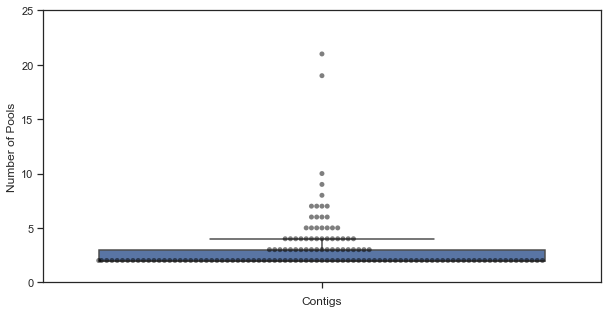

In [11]:
#Which contigs are most shared based on length (more then 5kb), and TPmean (> 10)?
#os.listdir()
tpmean = pd.read_csv("data/coverage_tpmean.tsv", sep="\t")
del tpmean['Length']
tpmelt = tpmean.melt(id_vars='#contig')
tpcut = tpmelt[tpmelt['value'] > 10]
tpcut.to_csv("output/tpmean_melt_cut.tsv", sep='\t', index=False, header=False)
#Which samples have which contigs present?
#Structure: dictionary with sample as key, contigs as values.
sam_condic_tp10_5kb = {}
with open('output/tpmean_melt_cut.tsv') as f:
    for line in f:
        if str(line.strip().split()[1].replace('_filtered.bam', '')) in Dead:
            checkstrdead = str(line.strip().split()[1].replace('_filtered.bam', '')) + '_dead'
            if checkstrdead not in sam_condic_tp10_5kb:
                if int(line.strip().split()[0].split('_')[4]) > 5000:
                    sam_condic_tp10_5kb[checkstrdead] = [line.strip().split()[0]]
            else:
                if int(line.strip().split()[0].split('_')[4]) > 5000:
                    sam_condic_tp10_5kb[checkstrdead].append(line.strip().split()[0])
        if str(line.strip().split()[1].replace('_filtered.bam', '')) in Alive:
            checkstral = str(line.strip().split()[1].replace('_filtered.bam', '')) + '_alive'
            if checkstral not in sam_condic_tp10_5kb:
                if int(line.strip().split()[0].split('_')[4]) > 5000:
                    sam_condic_tp10_5kb[checkstral] = [line.strip().split()[0]]
            else:
                if int(line.strip().split()[0].split('_')[4]) > 5000:
                    sam_condic_tp10_5kb[checkstral].append(line.strip().split()[0])
        if str(line.strip().split()[1].replace('_filtered.bam', '')) not in Dead and str(line.strip().split()[1].replace('_filtered.bam', '')) not in Alive:
            print('problem with: ' + str(line.strip().split()[1].replace('_filtered.bam', '')))
#Dictionary done.
#Create a reverse datastructure, to see which contigs are in which samples
#Structure: dictionary with contig as key, samples as values
con_samdic_tp10_5kb = {}
contigs_tp10_5kb = []
for i in sam_condic_tp10_5kb:
    for j in sam_condic_tp10_5kb[i]:
        if j not in con_samdic_tp10_5kb:
            con_samdic_tp10_5kb[j] = [i]
        else:
            con_samdic_tp10_5kb[j].append(i)
        if j not in contigs_tp10_5kb:
            contigs_tp10_5kb.append(j)
con_samcount_tp10_5kb = {}
for i in con_samdic_tp10_5kb:
    con_samcount_tp10_5kb[i] = len(con_samdic_tp10_5kb[i])
morethan1 = 0
for i in con_samcount_tp10_5kb:
    if con_samcount_tp10_5kb[i] > 1:
        morethan1 += 1
morethan5 = 0
for i in con_samcount_tp10_5kb:
    if con_samcount_tp10_5kb[i] > 4:
        morethan5 += 1
#Print some stats to terminal:
print('In Total: ' + str(len(con_samcount_tp10_5kb)) + ' Survive 10tpmean-5kb treshold.')
print('Out of '+ str(len(con_samcount_tp10_5kb)) + ' Surviving, ' + str(morethan1) + ' are present in more than 1 sample')
print('Out of '+ str(len(con_samcount_tp10_5kb)) + ' Surviving, ' + str(morethan5) + ' are present in 5 or more samples')
#In this case, we want to grab the contig names of those that are present in 5 or more samples:
#And get the samples name also.
abphages = []
absamples = []
for i in con_samdic_tp10_5kb:
    if len(con_samdic_tp10_5kb[i]) > 4:
        abphages.append(i)
        for j in con_samdic_tp10_5kb[i]:
            if 'dead' in j:
                if j.replace('dead','filtered.bam') not in absamples:
                    absamples.append(j.replace('dead','filtered.bam'))
            if 'alive' in j:
                if j.replace('alive','filtered.bam') not in absamples:
                    absamples.append(j.replace('alive','filtered.bam'))
#Barplots
#Throw in dataframe and sort.
tp10_5kbcountDF = pd.Series(con_samcount_tp10_5kb).to_frame('Count')
tp10_5kbcountDF = tp10_5kbcountDF.sort_values(['Count'], ascending=False).reset_index(drop=False)
tp10_5kbcountDF = tp10_5kbcountDF[tp10_5kbcountDF['Count'] > 1]
#Save figure
plt.figure(figsize=(10,5))
g = sns.boxplot(y=tp10_5kbcountDF['Count'], showfliers=False)
g = sns.swarmplot(y=tp10_5kbcountDF['Count'], alpha=0.5, color='black')
g.set(ylim=(0,25))
g.set(xlabel='Contigs',ylabel='Number of Pools')
g.figure.savefig('figures/Boxplot_numsam.png', dpi=300)

,index,Count
0,BeeP-17-2013_NODE_8_length_19907_cov_39_552295,21
1,BeeP-45-2013_NODE_2_length_27560_cov_75_850817,19
2,BP19_NODE_3_length_17422_cov_18_925264,10
3,BP34_NODE_4_length_5102_cov_4_094359,9
4,BP50_NODE_3_length_63344_cov_156_042817,8
...,...,...
135,BeeP-25-2013_NODE_4_length_19295_cov_37_789104,2
136,BeeP-14-2013_NODE_2_length_6247_cov_6_674392,2
137,BeeP-25-2013_NODE_6_length_13913_cov_44_466103,2
138,BeeP-35-2013_NODE_20_length_15119_cov_38_743851,2


In [26]:
#Create networks.
#tpmean10: Samplenetwork
samplenet_tp10 = []
samplenet_tp10.append(['source','target','weight'])
for i in itertools.combinations(sam_condic_tp10_5kb.keys(), 2):
    sam1 = list(i)[0]
    sam2 = list(i)[1]
    number = len(list(set(sam_condic_tp10_5kb[sam1]) & set(sam_condic_tp10_5kb[sam2])))
    if number > 0:
        samplenet_tp10.append([sam1, sam2, number])
#And write the edgelist out for viz in other software:
with open('output/samplenet_tp10.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(samplenet_tp10)

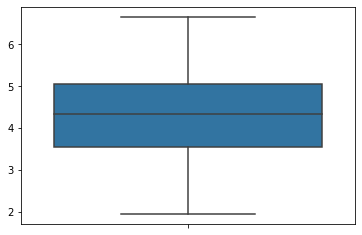

In [7]:
#Read in counts
count = pd.read_csv("data/counts.tsv", sep="\t", index_col=0)
#Divide the rows (which are contigs) by the length of the contig.
count = count.iloc[0:,:].div(count['Length'], axis=0)
del count['Length']
#Now divide over samples (colsums)
Total = count.sum(axis=0)
relcount = count.iloc[:,0:].div(Total, axis=1)
relcount['#contig'] = relcount.index
countmelt = relcount.melt(id_vars='#contig')
#Save if needed later.
countmelt.to_csv("output/relativecounts.tsv", sep='\t', index=False, header=False)

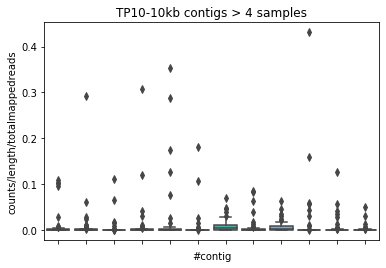

In [8]:
#Have a look at the distribution of the 'most shared contigs (calculated by tpmean 10 & 10kb.)'
abphagedf = countmelt[countmelt['#contig'].isin(abphages)]
abphagedf = abphagedf[abphagedf['variable'].isin(absamples)]
g = sns.boxplot(x=abphagedf['#contig'],y=abphagedf['value'])
g.set(xticklabels=[])
g.set(ylabel='counts/length/totalmappedreads', title='TP10-10kb contigs > 4 samples')
g

In Total: 112 Survive rel1-10kb treshold.
Out of 112 Surviving, 62 are present in more than 1 sample
Out of 112 Surviving, 22 are present in 5 or more samples


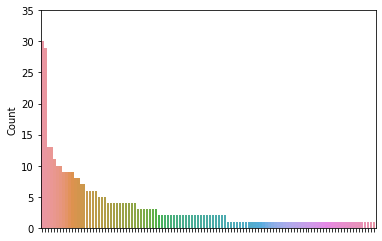

In [9]:
#Let's put the treshold for relcount at 0.01 (seems reasonable) + keep 10kb limit.
sam_condic_rel1_10kb = {}
with open('output/relativecounts.tsv') as f:
    for line in f:
        if int(line.strip().split()[0].split('_')[4]) > 10000:
            if str(line.strip().split()[1].replace('_filtered.bam', '')) in Dead:
                checkstrdead = str(line.strip().split()[1].replace('_filtered.bam', '')) + '_dead'
                if checkstrdead not in sam_condic_rel1_10kb:
                    if float(line.strip().split()[2]) >= 0.01:
                        sam_condic_rel1_10kb[checkstrdead] = [line.strip().split()[0]]
                else:
                    if float(line.strip().split()[2]) >= 0.01:
                        sam_condic_rel1_10kb[checkstrdead].append(line.strip().split()[0])
            if str(line.strip().split()[1].replace('_filtered.bam', '')) in Alive:
                checkstral = str(line.strip().split()[1].replace('_filtered.bam', '')) + '_alive'
                if checkstral not in sam_condic_rel1_10kb:
                    if float(line.strip().split()[2]) >= 0.01:
                        sam_condic_rel1_10kb[checkstral] = [line.strip().split()[0]]
                else:
                    if float(line.strip().split()[2]) >= 0.01:
                        sam_condic_rel1_10kb[checkstral].append(line.strip().split()[0])
#Create a reverse datastructure, to see which contigs are in which samples
#Structure: dictionary with contig as key, samples as values
con_samdic_rel1_10kb = {}
samples_rel1_10kb = []
for i in sam_condic_rel1_10kb:
    for j in sam_condic_rel1_10kb[i]:
        if j not in con_samdic_rel1_10kb:
            con_samdic_rel1_10kb[j] = [i]
        else:
            con_samdic_rel1_10kb[j].append(i)
        if j not in samples_rel1_10kb:
            samples_rel1_10kb.append(j)
con_samcount_rel1_10kb = {}
for i in con_samdic_rel1_10kb:
    con_samcount_rel1_10kb[i] = len(con_samdic_rel1_10kb[i])
morethan1 = 0
for i in con_samcount_rel1_10kb:
    if con_samcount_rel1_10kb[i] > 1:
        morethan1 += 1
morethan5 = 0
for i in con_samcount_rel1_10kb:
    if con_samcount_rel1_10kb[i] > 4:
        morethan5 += 1
#Print some stats to terminal:
print('In Total: ' + str(len(con_samcount_rel1_10kb)) + ' Survive rel1-10kb treshold.')
print('Out of '+ str(len(con_samcount_rel1_10kb)) + ' Surviving, ' + str(morethan1) + ' are present in more than 1 sample')
print('Out of '+ str(len(con_samcount_rel1_10kb)) + ' Surviving, ' + str(morethan5) + ' are present in 5 or more samples')
#Barplots
#Throw in dataframe and sort.
rel1_10kbcountDF = pd.Series(con_samcount_rel1_10kb).to_frame('Count')
rel1_10kbcountDF = rel1_10kbcountDF.sort_values(['Count'], ascending=False).reset_index(drop=False)
g = sns.barplot(x=rel1_10kbcountDF.index.values,y=rel1_10kbcountDF['Count'])
g.set(ylim=(0, 35))
g.set(xticklabels=[])
g

In [10]:
#1 more analysis, where we don't take into account the amount of mapped reads (only length)
#Read in counts
countlen = pd.read_csv("data/counts.tsv", sep="\t", index_col=0)
#Divide the rows (which are contigs) by the length of the contig.
countlen = countlen.iloc[0:,:].div(countlen['Length'], axis=0)
del countlen['Length']
countlen['#contig'] = countlen.index
countmeltlen = countlen.melt(id_vars='#contig')
#Save if needed later.
countmeltlen.to_csv("output/relativelength.tsv", sep='\t', index=False, header=False)

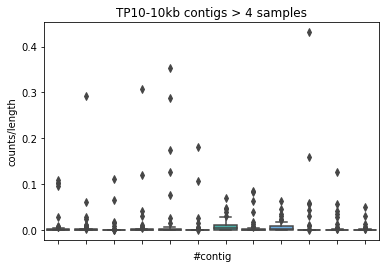

In [11]:
#Have a look at the distribution of the 'most shared contigs (calculated by tpmean 10 & 10kb.)'
abphagedflen = countmeltlen[countmeltlen['#contig'].isin(abphages)]
abphagedflen = abphagedflen[abphagedflen['variable'].isin(absamples)]
g = sns.boxplot(x=abphagedflen['#contig'],y=abphagedf['value'])
g.set(xticklabels=[])
g.set(ylabel='counts/length', title='TP10-10kb contigs > 4 samples')
g

In Total: 228 Survive rel1-10kb treshold.
Out of 228 Surviving, 140 are present in more than 1 sample
Out of 228 Surviving, 94 are present in 5 or more samples


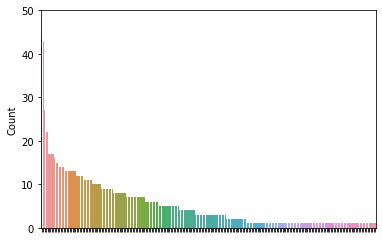

In [12]:
#Let's put the treshold for relcount (for length only here) at 0.01 (seems reasonable) + keep 10kb limit.
sam_condic_rellen_10kb = {}
with open('output/relativelength.tsv') as f:
    for line in f:
        if int(line.strip().split()[0].split('_')[4]) > 10000:
            if str(line.strip().split()[1].replace('_filtered.bam', '')) in Dead:
                checkstrdead = str(line.strip().split()[1].replace('_filtered.bam', '')) + '_dead'
                if checkstrdead not in sam_condic_rellen_10kb:
                    if float(line.strip().split()[2]) >= 0.01:
                        sam_condic_rellen_10kb[checkstrdead] = [line.strip().split()[0]]
                else:
                    if float(line.strip().split()[2]) >= 0.01:
                        sam_condic_rellen_10kb[checkstrdead].append(line.strip().split()[0])
            if str(line.strip().split()[1].replace('_filtered.bam', '')) in Alive:
                checkstral = str(line.strip().split()[1].replace('_filtered.bam', '')) + '_alive'
                if checkstral not in sam_condic_rellen_10kb:
                    if float(line.strip().split()[2]) >= 0.01:
                        sam_condic_rellen_10kb[checkstral] = [line.strip().split()[0]]
                else:
                    if float(line.strip().split()[2]) >= 0.01:
                        sam_condic_rellen_10kb[checkstral].append(line.strip().split()[0])
#Create a reverse datastructure, to see which contigs are in which samples
#Structure: dictionary with contig as key, samples as values
con_samdic_rellen_10kb = {}
samples_rellen_10kb = []
for i in sam_condic_rellen_10kb:
    for j in sam_condic_rellen_10kb[i]:
        if j not in con_samdic_rellen_10kb:
            con_samdic_rellen_10kb[j] = [i]
        else:
            con_samdic_rellen_10kb[j].append(i)
        if j not in samples_rellen_10kb:
            samples_rellen_10kb.append(j)
con_samcount_rellen_10kb = {}
for i in con_samdic_rellen_10kb:
    con_samcount_rellen_10kb[i] = len(con_samdic_rellen_10kb[i])
morethan1 = 0
for i in con_samcount_rellen_10kb:
    if con_samcount_rellen_10kb[i] > 1:
        morethan1 += 1
morethan5 = 0
for i in con_samcount_rellen_10kb:
    if con_samcount_rellen_10kb[i] > 4:
        morethan5 += 1
#Print some stats to terminal:
print('In Total: ' + str(len(con_samcount_rellen_10kb)) + ' Survive rel1-10kb treshold.')
print('Out of '+ str(len(con_samcount_rellen_10kb)) + ' Surviving, ' + str(morethan1) + ' are present in more than 1 sample')
print('Out of '+ str(len(con_samcount_rellen_10kb)) + ' Surviving, ' + str(morethan5) + ' are present in 5 or more samples')
#Barplots
#Throw in dataframe and sort.
rellen_10kbcountDF = pd.Series(con_samcount_rellen_10kb).to_frame('Count')
rellen_10kbcountDF = rellen_10kbcountDF.sort_values(['Count'], ascending=False).reset_index(drop=False)
g = sns.barplot(x=rellen_10kbcountDF.index.values,y=rellen_10kbcountDF['Count'])
g.set(ylim=(0, 50))
g.set(xticklabels=[])
g

In [17]:
#Create networks.
#tpmean10: Samplenetwork
samplenet_tp10 = []
samplenet_tp10.append(['source','target','weight'])
for i in itertools.combinations(sam_condic_tp10_10kb.keys(), 2):
    sam1 = list(i)[0]
    sam2 = list(i)[1]
    number = len(list(set(sam_condic_tp10_10kb[sam1]) & set(sam_condic_tp10_10kb[sam2])))
    if number > 0:
        samplenet_tp10.append([sam1, sam2, number])
#And write the edgelist out for viz in other software:
with open('output/network/samplenet_tp10.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(samplenet_tp10)

In [14]:
#Create networks:
#TPmean10: contignetwork
contignet_tp10 = []
contignet_tp10.append(['source','target','weight','sample'])
for i in itertools.combinations(con_samdic_tp10_10kb.keys(), 2):
    sam1 = list(i)[0]
    sam2 = list(i)[1]
    for j in list(set(con_samdic_tp10_10kb[sam1]) & set(con_samdic_tp10_10kb[sam2])):
        contignet_tp10.append([sam1,sam2,1,j])
#And write the edgelist out for viz in other software:
with open('output/network/contignet_tp10.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(contignet_tp10)

In [15]:
#Create networks:
#relcount: samplenetwork
samplenet_rel1 = []
samplenet_rel1.append(['source','target','weight'])
for i in itertools.combinations(sam_condic_rel1_10kb.keys(), 2):
    sam1 = list(i)[0]
    sam2 = list(i)[1]
    number = len(list(set(sam_condic_rel1_10kb[sam1]) & set(sam_condic_rel1_10kb[sam2])))
    if number > 0:
        samplenet_rel1.append([sam1, sam2, number])
#And write the edgelist out for viz in other software:
with open('output/network/samplenet_rel1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(samplenet_rel1)

In [16]:
#Create networks:
#relcount: contignetwork
contignet_rel1 = []
contignet_rel1.append(['source','target','weight','sample'])
for i in itertools.combinations(con_samdic_rel1_10kb.keys(), 2):
    sam1 = list(i)[0]
    sam2 = list(i)[1]
    for j in list(set(con_samdic_rel1_10kb[sam1]) & set(con_samdic_rel1_10kb[sam2])):
        contignet_rel1.append([sam1,sam2,1,j])
#And write the edgelist out for viz in other software:
with open('output/network/contignet_rel1.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(contignet_rel1)

In [17]:
#Create networks:
#rellen: samplenetwork
samplenet_rellen = []
samplenet_rellen.append(['source','target','weight'])
for i in itertools.combinations(sam_condic_rellen_10kb.keys(), 2):
    sam1 = list(i)[0]
    sam2 = list(i)[1]
    number = len(list(set(sam_condic_rellen_10kb[sam1]) & set(sam_condic_rellen_10kb[sam2])))
    if number > 0:
        samplenet_rellen.append([sam1, sam2, number])
#And write the edgelist out for viz in other software:
with open('output/network/samplenet_rellen.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(samplenet_rellen)

In [18]:
#Create networks:
#relcount: contignetwork
contignet_rellen = []
contignet_rellen.append(['source','target','weight','sample'])
for i in itertools.combinations(con_samdic_rellen_10kb.keys(), 2):
    sam1 = list(i)[0]
    sam2 = list(i)[1]
    for j in list(set(con_samdic_rellen_10kb[sam1]) & set(con_samdic_rellen_10kb[sam2])):
        contignet_rellen.append([sam1,sam2,1,j])
#And write the edgelist out for viz in other software:
with open('output/network/contignet_rellen.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(contignet_rellen)

In Total: 228 Survive 5tpmean-10kb treshold.
Out of 228 Surviving, 92 are present in more than 1 sample
Out of 228 Surviving, 22 are present in 5 or more samples


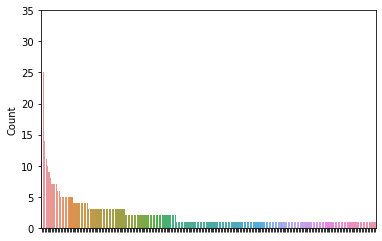

In [19]:
#Which contigs are most shared based on length (more then 10kb), and TPmean (> 5)?
#os.listdir()
tpmean = pd.read_csv("data/coverage_tpmean.tsv", sep="\t")
del tpmean['Length']
tpmelt = tpmean.melt(id_vars='#contig')
tpcut = tpmelt[tpmelt['value'] > 5]
tpcut.to_csv("output/tpmean_melt_cut_5.csv", sep='\t', index=False, header=False)
#Which samples have which contigs present?
#Structure: dictionary with sample as key, contigs as values.
sam_condic_tp5_10kb = {}
with open('output/tpmean_melt_cut_5.csv') as f:
    for line in f:
        if str(line.strip().split()[1].replace('_filtered.bam', '')) in Dead:
            checkstrdead = str(line.strip().split()[1].replace('_filtered.bam', '')) + '_dead'
            if checkstrdead not in sam_condic_tp5_10kb:
                if int(line.strip().split()[0].split('_')[4]) > 10000:
                    sam_condic_tp5_10kb[checkstrdead] = [line.strip().split()[0]]
            else:
                if int(line.strip().split()[0].split('_')[4]) > 10000:
                    sam_condic_tp5_10kb[checkstrdead].append(line.strip().split()[0])
        if str(line.strip().split()[1].replace('_filtered.bam', '')) in Alive:
            checkstral = str(line.strip().split()[1].replace('_filtered.bam', '')) + '_alive'
            if checkstral not in sam_condic_tp5_10kb:
                if int(line.strip().split()[0].split('_')[4]) > 10000:
                    sam_condic_tp5_10kb[checkstral] = [line.strip().split()[0]]
            else:
                if int(line.strip().split()[0].split('_')[4]) > 10000:
                    sam_condic_tp5_10kb[checkstral].append(line.strip().split()[0])
#Dictionary done.
#Create a reverse datastructure, to see which contigs are in which samples
#Structure: dictionary with contig as key, samples as values
con_samdic_tp5_10kb = {}
contigs_tp5_10kb = []
for i in sam_condic_tp5_10kb:
    for j in sam_condic_tp5_10kb[i]:
        if j not in con_samdic_tp5_10kb:
            con_samdic_tp5_10kb[j] = [i]
        else:
            con_samdic_tp5_10kb[j].append(i)
        if j not in contigs_tp5_10kb:
            contigs_tp5_10kb.append(j)
con_samcount_tp5_10kb = {}
for i in con_samdic_tp5_10kb:
    con_samcount_tp5_10kb[i] = len(con_samdic_tp5_10kb[i])
morethan1 = 0
for i in con_samcount_tp5_10kb:
    if con_samcount_tp5_10kb[i] > 1:
        morethan1 += 1
morethan5 = 0
for i in con_samcount_tp5_10kb:
    if con_samcount_tp5_10kb[i] > 4:
        morethan5 += 1
#Print some stats to terminal:
print('In Total: ' + str(len(con_samcount_tp5_10kb)) + ' Survive 5tpmean-10kb treshold.')
print('Out of '+ str(len(con_samcount_tp5_10kb)) + ' Surviving, ' + str(morethan1) + ' are present in more than 1 sample')
print('Out of '+ str(len(con_samcount_tp5_10kb)) + ' Surviving, ' + str(morethan5) + ' are present in 5 or more samples')
#In this case, we want to grab the contig names of those that are present in 5 or more samples:
#And get the samples name also.
abphages = []
absamples = []
for i in con_samdic_tp5_10kb:
    if len(con_samdic_tp5_10kb[i]) > 4:
        abphages.append(i)
        for j in con_samdic_tp5_10kb[i]:
            if 'dead' in j:
                if j.replace('dead','filtered.bam') not in absamples:
                    absamples.append(j.replace('dead','filtered.bam'))
            if 'alive' in j:
                if j.replace('alive','filtered.bam') not in absamples:
                    absamples.append(j.replace('alive','filtered.bam'))
#Barplots
#Throw in dataframe and sort.
tp5_10kbcountDF = pd.Series(con_samcount_tp5_10kb).to_frame('Count')
tp5_10kbcountDF = tp5_10kbcountDF.sort_values(['Count'], ascending=False).reset_index(drop=False)
g = sns.barplot(x=tp5_10kbcountDF.index.values,y=tp5_10kbcountDF['Count'])
g.set(ylim=(0, 35))
g.set(xticklabels=[])
g

In [20]:
#Create networks.
#tpmean5: Samplenetwork
samplenet_tp5 = []
samplenet_tp5.append(['source','target','weight'])
for i in itertools.combinations(sam_condic_tp5_10kb.keys(), 2):
    sam1 = list(i)[0]
    sam2 = list(i)[1]
    number = len(list(set(sam_condic_tp5_10kb[sam1]) & set(sam_condic_tp5_10kb[sam2])))
    if number > 0:
        samplenet_tp5.append([sam1, sam2, number])
#And write the edgelist out for viz in other software:
with open('output/network/samplenet_tp5.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(samplenet_tp5)

In [21]:
#Create networks:
#TPmean5: contignetwork
contignet_tp5 = []
contignet_tp5.append(['source','target','weight','sample'])
for i in itertools.combinations(con_samdic_tp5_10kb.keys(), 2):
    sam1 = list(i)[0]
    sam2 = list(i)[1]
    for j in list(set(con_samdic_tp5_10kb[sam1]) & set(con_samdic_tp5_10kb[sam2])):
        contignet_tp5.append([sam1,sam2,1,j])
#And write the edgelist out for viz in other software:
with open('output/network/contignet_tp5.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(contignet_tp5)

In [22]:
#Create networks:
#relcount: contignetwork
contignet_rellen_addinfo = []
contignet_rellen_addinfo.append(['source','target','weight','sampletype'])
for i in itertools.combinations(con_samdic_rellen_10kb.keys(), 2):
    sam1 = list(i)[0]
    sam2 = list(i)[1]
    if len(list(set(con_samdic_rellen_10kb[sam1]) & set(con_samdic_rellen_10kb[sam2]))) == 1:
        contignet_rellen_addinfo.append([sam1,sam2,1,list(set(con_samdic_rellen_10kb[sam1]) & set(con_samdic_rellen_10kb[sam2]))[0]])
    if len(list(set(con_samdic_rellen_10kb[sam1]) & set(con_samdic_rellen_10kb[sam2]))) > 1:
        contignet_rellen_addinfo.append([sam1,sam2,len(list(set(con_samdic_rellen_10kb[sam1]) & set(con_samdic_rellen_10kb[sam2]))),'mixed'])
with open('output/network/contignet_rellen_addinfo.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(contignet_rellen_addinfo)

In [42]:
#Generate the file contignet_rellen_modularitygroup.csv in gephi.
#This file is 'community calculation' based on the modularity of the network and will be used later.
modularitydic = {}
#Take all the contigs from coverage file, and assign (for now) them all to 'low group' (= low coverage).
allcontigs = {}
with open ('data/coverage_tpmean.tsv') as f:
    for line in f:
        if line.split()[0] != '#contig':
            allcontigs[line.split()[0]] = 'Low coverage'
#Now update the information for all the surviving contigs:
modinfocons = []
with open('data/contignet_rellen_modularitygroup.csv') as f:
    for line in f:
        if line.split(',')[0] != 'Id':
            modinfocons.append(line.split(',')[0])

with open('output/relativecounts.tsv') as f:
    for line in f:
        if float(line.strip().split()[2]) > 0.01:
            if line.strip().split()[0] not in modinfocons:
                if int(line.strip().split('_')[4]) < 10000:
                    allcontigs[line.strip().split()[0]] = 'High coverage'
#Finaly update with the modularity information:
with open('data/contignet_rellen_modularitygroup.csv') as f:
    for line in f:
        if line.split(',')[0] != 'Id':
            if int(line.strip().split(',')[1]) == 0:
                allcontigs[line.strip().split(',')[0]] = 'High modularity 0'
            if int(line.strip().split(',')[1]) == 1:
                allcontigs[line.strip().split(',')[0]] = 'High modularity 1'
            if int(line.strip().split(',')[1]) == 2:
                allcontigs[line.strip().split(',')[0]] = 'High modularity 2'
contigmodDF = pd.Series(allcontigs).to_frame('Group')
contigmodDF.to_csv('output/contigs_modularityinfo.csv')